# <center> Applications of No-Collision Transportation Maps in Manifold Learning  <center>
This notebook provides the main code to implement the no-collison map techinque from the paper "E. Negrini, L. Nurbekyan, Applications of No-Collision Transportation Maps in Manifold Learning ." 
The paper can be found here: 

For the comparison with Wassmap and LOT we use the original code provided in the corresponding papers:

# <center> Dilation Example, Section 7.2 <center>

In [38]:
############## Import statements ########################

import sklearn
import numpy as np
import ot
import ot.plot

# networkx is a graph library 
import networkx as nx

import time

from sklearn import manifold as man
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map as dm

import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse
from pydiffmap import diffusion_map as dm


# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

import math



from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

from mpl_toolkits.axes_grid1 import ImageGrid

#LOT functions
from Functions.LOT_ML import *
from Functions.Gaussians import *



#No-collision functions
from Functions.no_collision import *

#Wassmap functions
from Functions.WassmapFunctions import *

#Data generator
from Functions.DataGenerator import *


In [39]:
########## global figure settings ####################

%matplotlib inline
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
        'axes.titlesize': 20
         }

plt.rcParams.update(params)
 
font = {'family':'serif','weight':'normal','size':18}
plt.rc('font',**font)


Text(0.5, 1.0, 'Dilation grid')

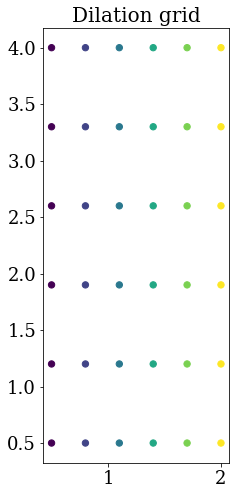

In [40]:
############# Dilation Grid Genaration #########################

num_samplepoints = 32
radius = 1
circ = generate_circle([0,0],radius,samples=num_samplepoints)

# Generate dilation set
num_dilates = 6
x = np.linspace(.5,2,num=num_dilates)
y = np.linspace(.5,4,num=num_dilates)
xx,yy = np.meshgrid(x,y) #num_dilates x num_dilates matrices; each xx,yy entry is a dilation vector
xx = np.reshape(xx,(num_dilates**2,1))
yy = np.reshape(yy,(num_dilates**2,1))
dilates = np.zeros((num_dilates**2,2))
for i in range(len(xx)):
    dilates[i,0] = xx[i]
    dilates[i,1] = yy[i]

# Plot the dilation set 
fig1,ax1 = plt.subplots()
ax1.scatter(dilates[:,0],dilates[:,1],s=40, c=dilates[:,0])
ax1.set_aspect('equal')
ax1.set_title('Dilation grid')


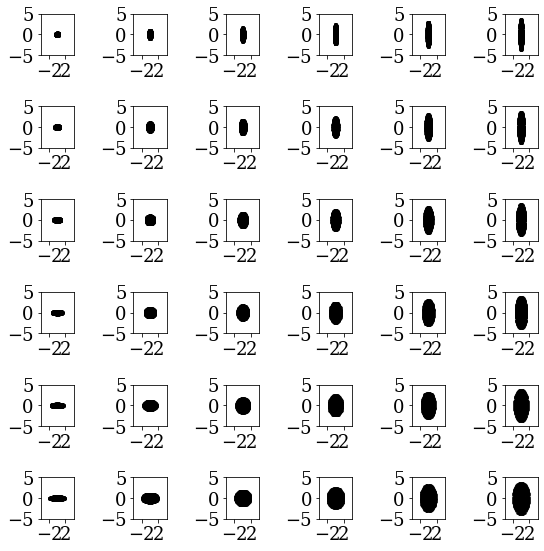

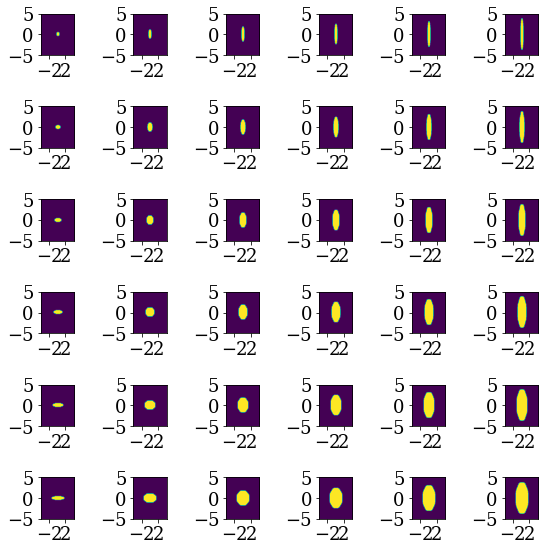

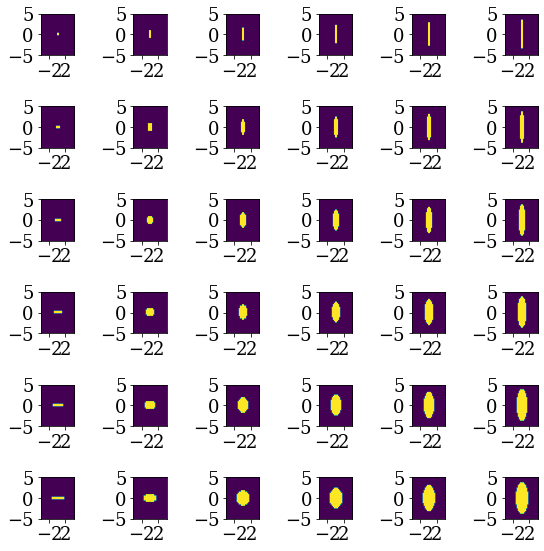

In [41]:
##################### Generate dilation images and image tensor #######################
dil_images = []
for i in range(num_dilates**2):
    img = np.concatenate((dilation(circ,[dilates[i,0],dilates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    dil_images.append(img)

# Generate voxel images

def voxel(nvox):

    # Generate voxel images (for LOT)
    nvox = nvox
    nxg = nvox
    nyg = nvox

    xg = np.linspace(-5,5,nxg)
    yg = np.linspace(-5,5,nyg)
    xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
    grid = np.stack((xxg,yyg))
    dil_images_vox = np.zeros((nvox,nvox,num_dilates**2))
    for i in range(num_dilates**2):
        pc = dil_images[i]
        dil_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
    return(dil_images_vox)

dil_images_vox_LOT = voxel(num_samplepoints)
dil_images_vox = voxel(128)



# Display pointcloud images
fig2,dilaxes = plt.subplots(num_dilates,num_dilates)
fig2.tight_layout()

xticks = np.linspace(-4,4,4)
yticks = np.linspace(-5,5,5)

idx = 0
for i in range(num_dilates): 
    for j in range(num_dilates):
        idx = i + num_dilates*j
        xxplt = dil_images[idx][:,0]
        yyplt = dil_images[idx][:,1]
        dilaxes[i,j].scatter(xxplt,yyplt,s=2,c='#000000')
        dilaxes[i,j].set_xlim([-4,4])
        dilaxes[i,j].set_ylim([-5,5])
        dilaxes[i,j].set_aspect('equal')
        dilaxes[i,j].set_xticks([-2,2])

# Display voxel images
fig3,dilaxes_vox = plt.subplots(num_dilates,num_dilates)
fig3.tight_layout()

idx = 0
for i in range(num_dilates): 
    for j in range(num_dilates):
        idx = i + num_dilates*j
        dilaxes_vox[i,j].imshow(dil_images_vox[:,:,idx],origin='lower',extent = (-4,4,-5,5))
        dilaxes_vox[i,j].set_xticks([-2,2])
plt.show()

fig4,dilaxes_vox = plt.subplots(num_dilates,num_dilates)
fig4.tight_layout()

idx = 0
for i in range(num_dilates): 
    for j in range(num_dilates):
        idx = i + num_dilates*j
        dilaxes_vox[i,j].imshow(dil_images_vox_LOT[:,:,idx],origin='lower',extent = (-4,4,-5,5))
        dilaxes_vox[i,j].set_xticks([-2,2])
plt.show()

In [42]:
##################### Compute Wasserstein square distance matrix #####################
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(dil_images,squared=False)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samplepoints,toc))


#################### Wassmap Embedding: MDS on Wass squared matrix #####################
WassEmbedding = MDS(Wass_distance,squared=False)



Computed Wasserstein distance matrix (N = 32) in 72.1496 seconds


In [43]:
##################### Euclidean Embeddings #####################

temp = np.reshape(dil_images_vox.T,[dil_images_vox.shape[-1],dil_images_vox.shape[0]**2])
dil_embedded_isomap = man.Isomap(n_neighbors=2,n_components=2,metric='euclidean',).fit_transform(temp)
dil_embedded_MDS = man.MDS(n_components=2,metric='euclidean',).fit_transform(temp)
dil_embedded_DiffMap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 0.5, k=64).fit_transform(temp)


In [48]:
##################### No-collision Features #####################

NN_CM = 2
NN_GC = 6

imgVox_NoC = dil_images_vox.T

tic_NoC = time.perf_counter()
X_testCM, _ = features_mat(imgVox_NoC,NN_CM)
toc_NoC = time.perf_counter() - tic_NoC

_, X_testGC = features_mat(imgVox_NoC,NN_GC)

##################### No-collision Embedding #####################

mnist_embedded_MDS_NOcCM = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testCM)
mnist_embedded_MDS_NOcGC = man.MDS(n_components=2,metric='euclidean',).fit_transform(X_testGC)

time LOT 0.9664008180843666


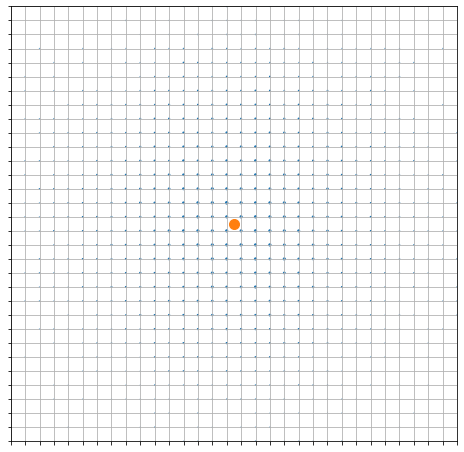

In [49]:
##################### LOT Features #####################
dilations = dil_images_vox_LOT.transpose(2,0,1)
N_total = dilations.shape[0]
dilations = dilations.reshape(N_total, -1)

#Define references. Options are "true (even number of references)", "sheared (even number of references)", "Gaussian (1 or 5)"
n_ref = 1
ref_type = "Gaussian"

grid_size = num_samplepoints
x = np.linspace(0,grid_size-1,grid_size)
y = np.linspace(0,grid_size-1,grid_size)
num_gridPoints = range(0,grid_size)
grid_points=[]
for i in range(0,grid_size):
    for j in range(0,grid_size):
        grid_points.append([x[i], y[j]])
grid_points = np.asarray(grid_points)

#Mean and covariance for a Gaussian reference distribution
if ref_type == "Gaussian":
    if n_ref == 1:
        mu = np.array([(grid_size-1)/2,(grid_size-1)/2])
        sigma = 5
        Skew = np.array([[1,0],[0,1]])
        cov = pow(sigma,2)*Skew#np.identity(2)
        GaussianSamples, GaussianReference = DiscreteGaussian(mu,cov,x,y,grid_size,10000)
    elif n_ref == 5:
        mu_center = np.array([(grid_size-1)/2, (grid_size-1)/2])
        cov_center = pow(3,2)*np.identity(2)
        mu_1 = mu_center + np.array([-(grid_size-1)/3, -(grid_size-1)/3])
        mu_2 = mu_center + np.array([-(grid_size-1)/3, (grid_size-1)/3])
        mu_3 = mu_center + np.array([(grid_size-1)/3, -(grid_size-1)/3])
        mu_4 = mu_center + np.array([(grid_size-1)/3, (grid_size-1)/3])
        cov = pow(2,2)*np.identity(2)
        GaussianSamples_center, GaussianReference_center = DiscreteGaussian(mu_center,cov_center,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_sw = DiscreteGaussian(mu_1,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_nw = DiscreteGaussian(mu_2,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_se = DiscreteGaussian(mu_3,cov,x,y,grid_size,10000)
        GaussianSamples_tmp, GaussianReference_ne = DiscreteGaussian(mu_4,cov,x,y,grid_size,10000)        

if n_ref == 5 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_center)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_sw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_nw)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_se)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference_ne)
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #ax.set(title="Five Gaussian references")
    #plt.savefig("Images/Gaussianref5.png",bbox_inches="tight",facecolor="w",dpi=500)
elif n_ref == 1 and ref_type == "Gaussian":
    fig, ax = plt.subplots(1,1)
    ax.scatter(grid_points[:,0],grid_points[:,1],s=750*GaussianReference)
    ax.scatter(mu[0],mu[1], s = 100)
    #ax.set_title("Single Gaussian reference",fontweight="bold")
    ax.set_xlim([0,grid_size-1])
    ax.set_ylim([0,grid_size-1])
    ax.set_xticks(num_gridPoints)
    ax.set_yticks(num_gridPoints)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(labelbottom=False)    
    ax.tick_params(labelleft=False) 
    #plt.savefig("Images/Gaussianref1.png",bbox_inches="tight",facecolor="w",dpi=500)

    
#Squared Euclidean Cost matrix between the grid points
Cost = ot.dist(grid_points, grid_points, metric = "sqeuclidean")

reference = np.empty((n_ref,grid_size**2))

#Select reference images for "true" and "sheared" types
if ref_type != "Gaussian":
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[i] = ReferencePoolClass1[tmp_indx].flatten()
        elif ref_type == "sheared":        
            reference[i] = Pixels[id1][tmp_indx]
        reference[i] = (1/np.sum(reference[i]))*reference[i]
        
        
    for i in range(0,int(n_ref/2)):
        tmp_indx = np.random.randint(N_total-25,N_total)
        if ref_type == "true":
            reference[int(n_ref/2)+i] = ReferencePoolClass2[tmp_indx].flatten()
        elif ref_type == "sheared":
            reference[int(n_ref/2)+i] = Pixels[id2][tmp_indx]
        reference[int(n_ref/2)+i] = (1/np.sum(reference[int(n_ref/2)+i]))*reference[int(n_ref/2)+i]

elif ref_type == "Gaussian":
    if n_ref == 1:
        reference[0] = GaussianReference
    elif n_ref == 5:
        reference[0] = GaussianReference_center
        reference[1] = GaussianReference_sw
        reference[2] = GaussianReference_nw
        reference[3] = GaussianReference_se
        reference[4] = GaussianReference_ne
    for i in range(0,n_ref):
        reference[i] = (1/np.sum(reference[i]))*reference[i]
        

        
##################### LOT Embedding #####################
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

EmbeddingClass1 = []
tic_LOT = time.perf_counter()
for i in range(0,N_total):
    template = dilations[i]
    template = (1/np.sum(template))*template
        
    Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
#     print('embedding shape', Embedding.shape)
    
    for j in range(1,n_ref):
        tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
        Embedding = np.concatenate((Embedding,tmp1),axis=0)
        Support = np.concatenate((Support,tmp2),axis=0)
        del tmp1, tmp2

    EmbeddingClass1.append(Embedding)
toc_LOT = time.perf_counter() - tic_LOT    

print('time LOT',toc_LOT )

LOT_DilFeatures = np.array(EmbeddingClass1).reshape(len(EmbeddingClass1),-1)

LOT_MDSDil = man.MDS(n_components=2,metric='euclidean',).fit_transform(LOT_DilFeatures)

 Error LOT Distance =  6.2077 % 
 Error no-coll CM Distance =  1.4037 % 
 Error no-coll GC Distance =  3.3237 %


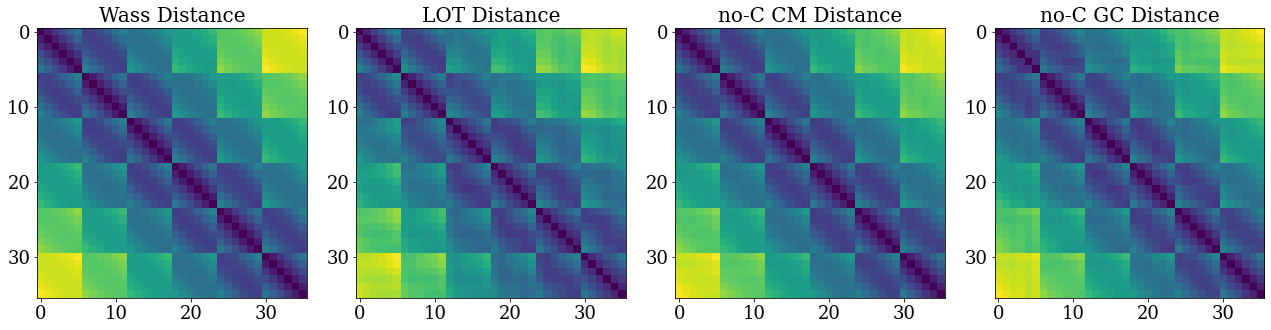

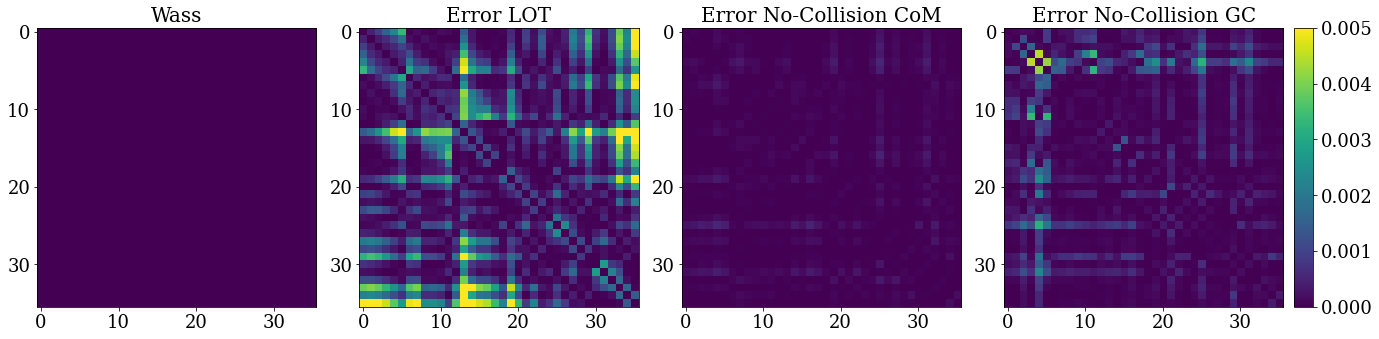

In [50]:
###################### Distance Matrix Approximation ############################

LOTDist = NormalizeData(pairwiseDist(LOT_DilFeatures)**0.5)
noCMDist = NormalizeData(pairwiseDist(X_testCM)**0.5)
noGCDist = NormalizeData(pairwiseDist(X_testGC)**0.5)
Wass_distance_norm = NormalizeData(Wass_distance)

MDSnoCM= man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(pairwiseDist(X_testCM)**0.5)
MDSnoGC= man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(pairwiseDist(X_testGC)**0.5)

print(' Error LOT Distance = ',relErr(Wass_distance_norm, LOTDist),'% \n',
'Error no-coll CM Distance = ',relErr(Wass_distance_norm, noCMDist), '% \n',
'Error no-coll GC Distance = ',relErr(Wass_distance_norm, noGCDist), '%')


fig = plt.figure(figsize=(18,5))
plt.subplot(1,4,1)
plt.imshow(Wass_distance_norm)
plt.title('Wass Distance')

plt.subplot(1,4,2)
plt.imshow(LOTDist)
plt.title('LOT Distance')

plt.subplot(1,4,3)
plt.imshow(noCMDist)
plt.title('no-C CM Distance')

plt.subplot(1,4,4)
plt.imshow(noGCDist)
plt.title('no-C GC Distance')

plt.tight_layout()

fig = plt.figure(figsize=(19.5,5))
dists =[Wass_distance_norm,LOTDist,noCMDist,noGCDist]
titles =['Wass','Error LOT','Error No-Collision CoM','Error No-Collision GC' ]

top_lim = 0.005
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,4),
                 axes_pad=0.6,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 label_mode="all"
                 )

for i,ax in enumerate(grid):
    im =ax.imshow((dists[i]-Wass_distance_norm)**2, vmin=0, vmax = top_lim)
    ax.set_title(titles[i])
    
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.tight_layout() 
    

Number of transaltion samples =  36
Time for Wass Embedding =  72.14962568401825
Time for no-collision Embedding, (N=4) =  0.14236728590913117
Time for LOT Embedding =  0.9664008180843666


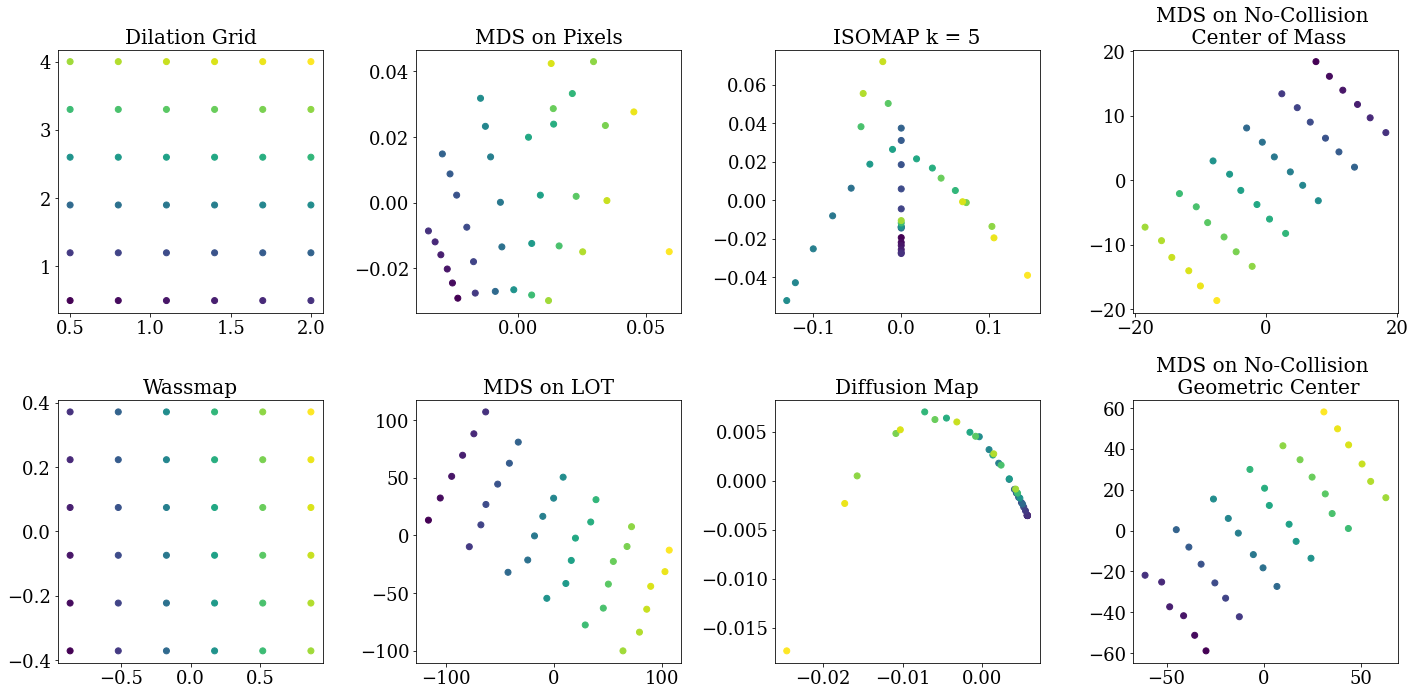

In [51]:
################# Embedding Comparison ################################

print("Number of transaltion samples = ", num_dilates**2)
print("Time for Wass Embedding = ", toc)
print("Time for no-collision Embedding, (N=4) = ",toc_NoC)
print("Time for LOT Embedding = ", toc_LOT)

c = np.linspace(0,1, len(dilates[:,0]))

plt.figure(figsize = (20,10))
plt.subplot(241)
plt.scatter(dilates[:,0],dilates[:,1], c = c)
plt.title("Dilation Grid")

plt.subplot(242)
scatter_x = dil_embedded_MDS[:,0]
scatter_y = dil_embedded_MDS[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on Pixels")

plt.subplot(243)
scatter_x = dil_embedded_isomap[:,0]
scatter_y = dil_embedded_isomap[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("ISOMAP k = 5")

plt.subplot(245)
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
plt.scatter(scatter_x,scatter_y, c = c)
plt.title("Wassmap")

plt.subplot(244)
scatter_x = mnist_embedded_MDS_NOcCM[:,0]
scatter_y = mnist_embedded_MDS_NOcCM[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on No-Collision \n Center of Mass")

plt.subplot(248)
scatter_x = mnist_embedded_MDS_NOcGC[:,0]
scatter_y = mnist_embedded_MDS_NOcGC[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on No-Collision \n Geometric Center")

plt.subplot(247)
scatter_x = dil_embedded_DiffMap[:,0]
scatter_y = dil_embedded_DiffMap[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("Diffusion Map")

plt.subplot(246)
scatter_x = LOT_MDSDil[:,0]
scatter_y = LOT_MDSDil[:,1]
plt.scatter(scatter_x, scatter_y, c = c)
plt.title("MDS on LOT")


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Time (s) v.s. Dilation Points')

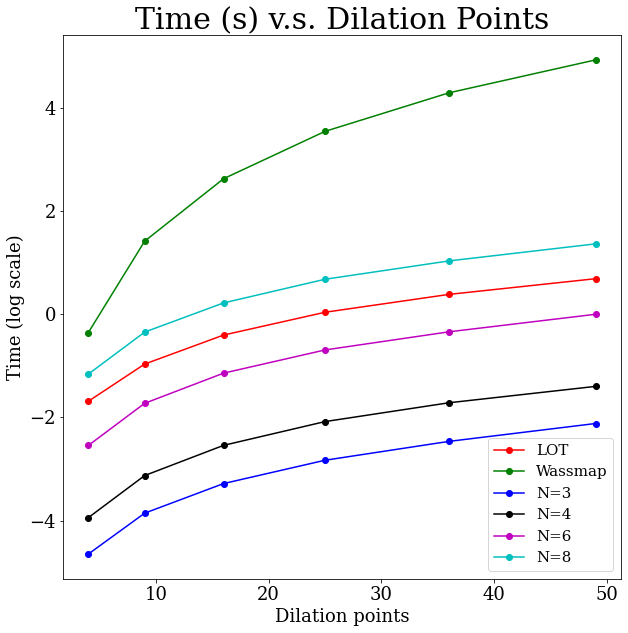

In [52]:
############### Computational Time Comparison ##################

num_samplepoints = 32
radius = 1
circ = generate_circle([0,0],radius,samples=num_samplepoints)

# Generate dilation set
# Generate translation set 1
dilating_pts = [i for i in range(2,8)]
timeLOT = []
timeWass = []
timeN2 = []
timeN4 = []
timeN6 = []
timeN8 = []
timeN10 = []
for num_dilates in dilating_pts:
    x = np.linspace(.5,2,num=num_dilates)
    y = np.linspace(.5,4,num=num_dilates)
    xx,yy = np.meshgrid(x,y) #num_dilates x num_dilates matrices; each xx,yy entry is a dilation vector
    xx = np.reshape(xx,(num_dilates**2,1))
    yy = np.reshape(yy,(num_dilates**2,1))
    dilates = np.zeros((num_dilates**2,2))
    for i in range(len(xx)):
        dilates[i,0] = xx[i]
        dilates[i,1] = yy[i]

    # Generate dilation images and image tensor
    dil_images = []
    for i in range(num_dilates**2):
        img = np.concatenate((dilation(circ,[dilates[i,0],dilates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
        dil_images.append(img)

    # Generate voxel images (for ISOMAP)
    nvox = 32
    nxg = nvox
    nyg = nvox

    xg = np.linspace(-2,2,nxg)
    yg = np.linspace(-4,4,nyg)
    xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
    grid = np.stack((xxg,yyg))
    dil_images_vox = np.zeros((nvox,nvox,num_dilates**2))
    for i in range(num_dilates**2):
        pc = dil_images[i]
        dil_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
        
        
    #####################################LOT##############################################
    #the reference is independent of the data so we define it only once above
    dilations = dil_images_vox.transpose(2,0,1)
    N_total = dilations.shape[0]
    dilations = dilations.reshape(N_total, -1)
        
    #EmbeddingLOT
    #Import required packages
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

    EmbeddingClass1 = []
    tic_LOT = time.perf_counter()
    for i in range(0,N_total):
        template = dilations[i]
        template = (1/np.sum(template))*template

        Embedding, Support = FullDiscreteEmbed(template,reference[0],Cost,grid_size) 
    #     print('embedding shape', Embedding.shape)

        for j in range(1,n_ref):
            tmp1, tmp2 = FullDiscreteEmbed(template,reference[j],Cost,grid_size)
            Embedding = np.concatenate((Embedding,tmp1),axis=0)
            Support = np.concatenate((Support,tmp2),axis=0)
            del tmp1, tmp2

        EmbeddingClass1.append(Embedding)
        
    toc_LOT = time.perf_counter() - tic_LOT    
    timeLOT.append(toc_LOT)
    
    
    
     ## Circle translation test :: Compute Wasserstein square distance matrix
    tic = time.perf_counter()
    Wass_distance_trans = Wasserstein_Matrix(dil_images,squared=False)
    toc = time.perf_counter() - tic
    timeWass.append(toc)
    
    NN = 3
    imgVox_NoC = dil_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN2.append(toc_NoC)
    
    NN = 4
    imgVox_NoC = dil_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN4.append(toc_NoC)
    
    NN = 6
    imgVox_NoC = dil_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN6.append(toc_NoC)
    
    NN = 8
    imgVox_NoC = dil_images_vox.T
    tic_NoC = time.perf_counter()
    X_testCM, X_testGC = features_mat(imgVox_NoC,NN)
    toc_NoC = time.perf_counter() - tic_NoC
    timeN8.append(toc_NoC)
        
dilating_pts = [i**2 for i in range(2,8)]

plt.figure(figsize = (10,10))

plt.plot(dilating_pts, np.log(timeLOT),'-o',label ='LOT', c = 'r')
plt.plot(dilating_pts, np.log(timeWass),'-o',label ='Wassmap', c = 'g')
plt.plot(dilating_pts, np.log(timeN2),'-o', label ='N=3', c = 'b')
plt.plot(dilating_pts, np.log(timeN4),'-o', label ='N=4',c = 'k')
plt.plot(dilating_pts, np.log(timeN6),'-o', label ='N=6', c = 'm')
plt.plot(dilating_pts, np.log(timeN8),'-o', label ='N=8',c = 'c')
plt.legend(prop={'size': 15}, loc = 'lower right')
plt.xlabel('Dilation points',fontsize = 18)
plt.ylabel('Time (log scale)',fontsize = 18)
plt.title('Time (s) v.s. Dilation Points', fontsize = 30)
    